In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_lfw_dataset

## Classification of Faces
----

Face classification is a common problem in computer vision. From Facebook to airports, identifying individuals automatically has many possible utilities. In this notebook we are going to use this application as test-case for 2D convolutional neural networks (CNNs). 

It has been known for a long time that face classification is not a *difficult* problem, at least compared to general-case object recognition and unconstrained image classification. Identifying face regions in an image takes a bit of work, but the geometrical face structure is a very regular, and can be modelled very well just through principal component analysis (PCA). By projecting onto a low-dimensional space, it becomes practical to train classifiers via logistic regression or support vector machines (SVM). Often this soves the problem quite well.

Using CNNs for this task is a bit of overkill, but it gives us a problem that we can easily work on with limited training data, limited training horsepower (laptops in $<$10 min), and still get a reasonable result.

We are going to work with a dataset called `Labelled Faces in the Wild` (LFW). [You can find the full description of the dataset here](http://vis-www.cs.umass.edu/lfw/). Also, you will need to download the dataset (~100Mb) and store it on your HDD. The version of the dataset we wish to use is the **Deep Funneled** version which contains pre-aligned and centered images of the faces. This helps us avoid a lot of messy pre-processing. 

* [Download Link for **Deep Funneled** LFW Dataset.](http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz)

We have prepared a function which already takes care of the data-loading and formatting. We will work with a small subset of the dataset, one containing only individuals for which more than ~50 face images exist. This reduces the amount of data to work with. 

Additionally, the original images are of size $250\times 250$ pixels. This is a bit larger than we want to work with on our laptops, so we scale the images down to a size of $125\times 125$ pixels. The loading function also applys a shuffling of the dataset, so we set the state of the random number generator (kwarg `random_state`) so that we all get close to the same results for this demonstration.

In [3]:
#--- Load our LFW Data ---#
(X, y, names) = load_lfw_dataset(min_num_faces=49, scale=0.5, data_home='./mldata', random_state=42)
print('Dataset Dimensions: ', X.shape)

Dataset Dimensions:  (1609, 125, 125, 3)


Lets take a look at the dataset in an abbreviated fashion. This is just for fun and to get an idea of the data. We'll make a portrait of each individual in the dataset by a simple averaging of their images display the resulting mean.

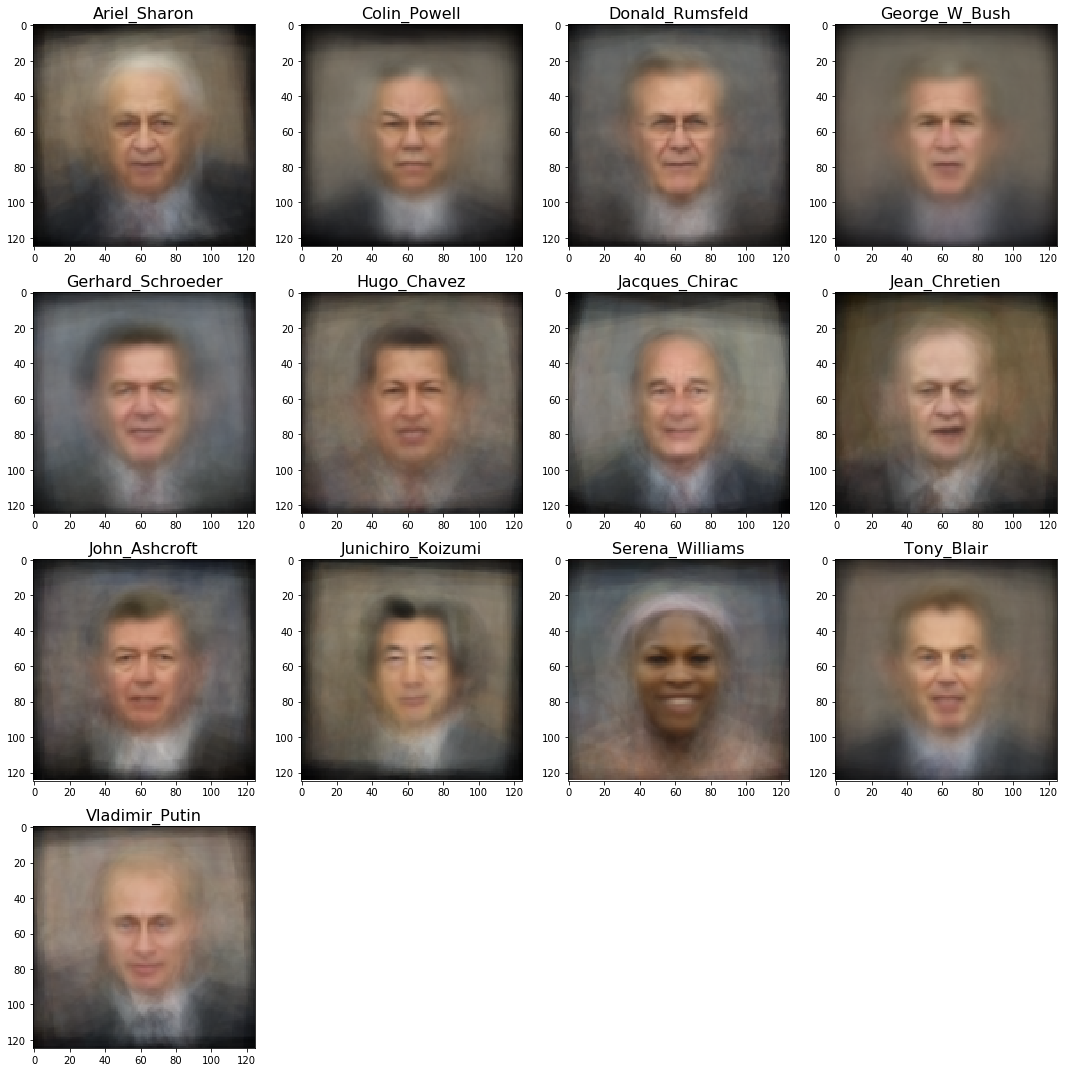

In [4]:
#--- View People in Dataset ---#
num_people = len(names)

L = int(np.sqrt(num_people)) + 1

plt.figure(figsize=(15,15))

for i in range(0,num_people):
    plt.subplot(L,L,i+1)
    plt.imshow(np.mean(X[y==i, :, :, :], axis=0))
    plt.title(names[i], fontsize=16)

plt.tight_layout()

An important facet of effective practical ML is to focus on known predictive features. In this case, we want to have a model which is focused on classifying *faces*, not the background. So, we can reduce the complexity of our model by taking a center crop of the face images. 

Dataset Dimensions:  (1609, 95, 75, 3)


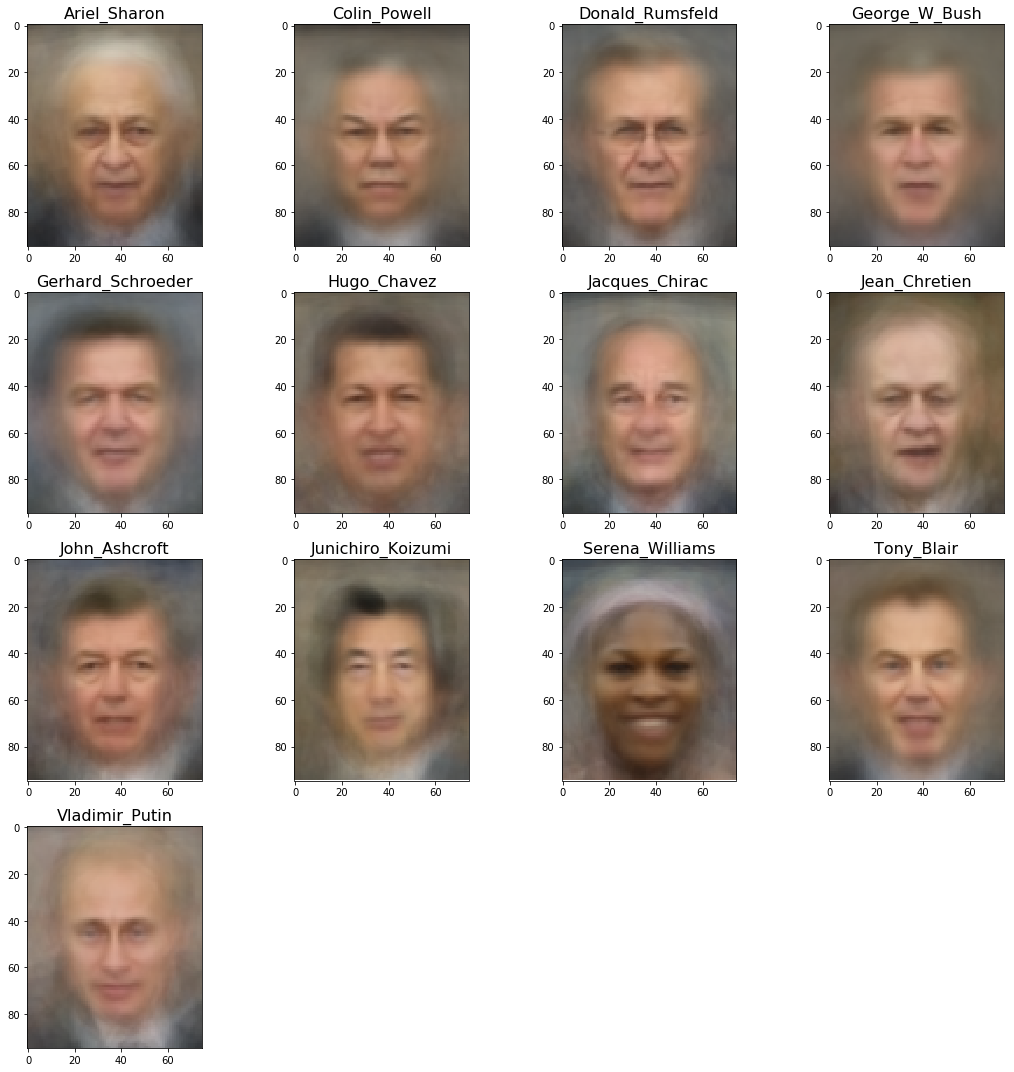

In [5]:
#--- Crop to Faces ---#
# Get crop dimensions
vert_dim  = X.shape[1]
horz_dim  = X.shape[2] 
horz_crop = (int(0.2*horz_dim), int(0.8*horz_dim))
vert_crop = (int(0.08*vert_dim), int(0.84*vert_dim))   
# Make crop
X = X[:, vert_crop[0]:vert_crop[1], horz_crop[0]:horz_crop[1], :]
print('Dataset Dimensions: ', X.shape)
# Save this new dimension
img_dim = (X.shape[1], X.shape[2], 3)

#--- Display ---#
plt.figure(figsize=(15,15))

for i in range(0,num_people):
    plt.subplot(L,L,i+1)
    plt.imshow(np.mean(X[y==i, :, :, :], axis=0))
    plt.title(names[i], fontsize=16)

plt.tight_layout()

Now lets go ahead and make a train-test split and set aside some test data in order to compare our models.

In [6]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

print('Train Dataset Shape: ', X.shape)
print('Test Dataset Shape: ', X_test.shape)

Train Dataset Shape:  (1448, 95, 75, 3)
Test Dataset Shape:  (161, 95, 75, 3)


Now, lets take a look at what we can know about this dataset in the simplest possible way. This is just to get an idea of the main axes that separate images from one another. We can do this by looking at the principal components (PC) of the dataset (e.g. the PCA). To do this, we first need to flatten the dataset.

In [14]:
#--- Take a look at the PCA ---#
def flatten(X):
    XFlat = np.empty((X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]), dtype=float)
    for i in range(X.shape[0]):
        XFlat[i,:] = np.squeeze(X[i, :, :, :]).ravel() 
    
    return XFlat
    

XFlat = flatten(X)
XFlat_test = flatten(X_test)

print('Flattened Dimensions: ', XFlat.shape)           

Flattened Dimensions:  (1448, 21375)


Now we can use Scikit-Learn to find the PCs.

In [8]:
from sklearn.decomposition import PCA

#--- Calculate PCA Transform ---#
pca = PCA(n_components=100)
pca.fit(XFlat)
# Find projection of dataset onto PCs
XPCA = pca.transform(XFlat)
# Find values of the PCs themselves
PCS = pca.components_

Lets take a look at what the PCs are. Since these PCs are generated from an SVD, these are essentially orthogonal basis vectors which best describe the variation in the dataset. Additionally, scikit-learn gives the components in an ordered fashion, e.g. the first PC is the vector which describes the maximal direction of variation in the dataset. Below we plot the top 25 PCs.

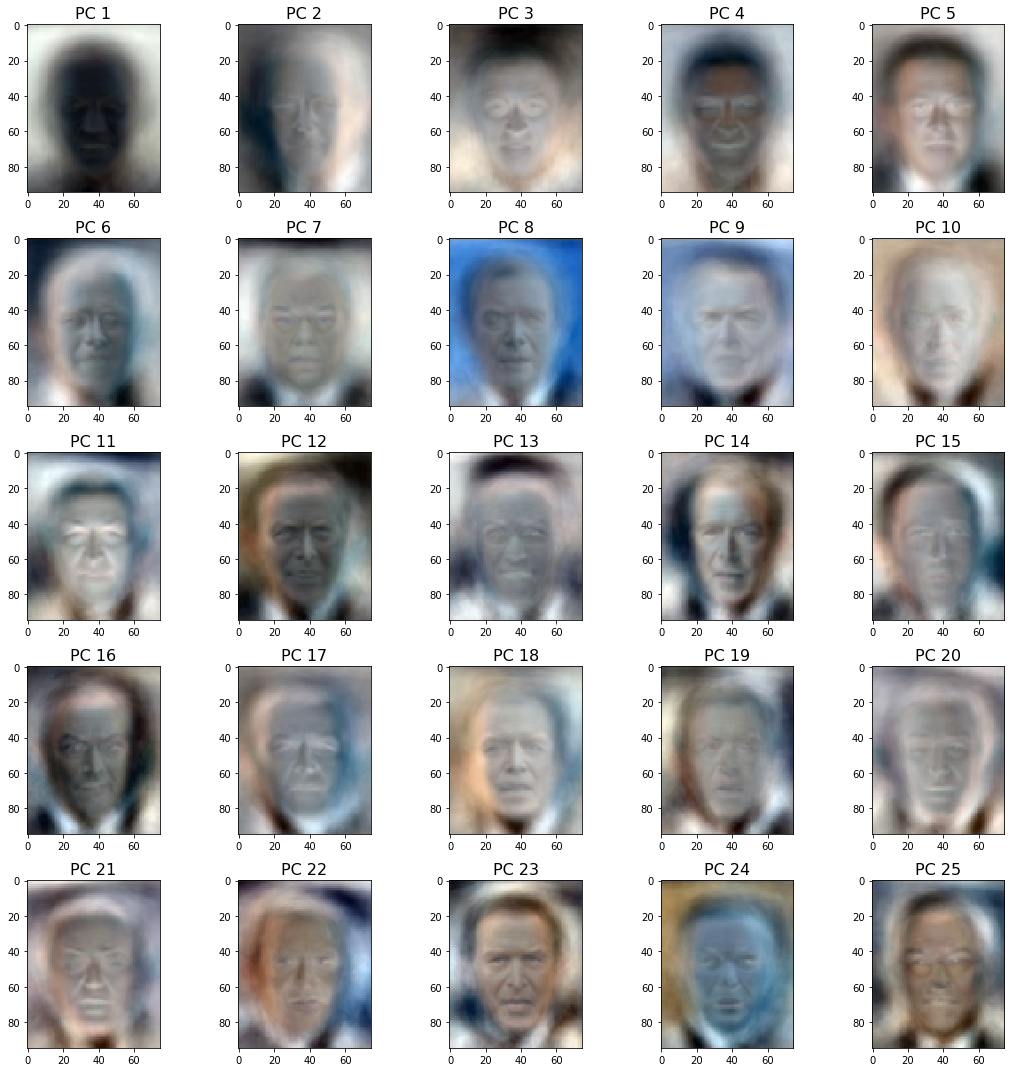

In [9]:
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    comp = PCS[i,:]
    comp = (comp - np.min(comp)) / (np.max(comp) - np.min(comp))
    plt.imshow(np.reshape(comp,(95,75,3)))
    plt.title('PC %s' % str(i+1), fontsize=16)

plt.tight_layout()

Now, just looking at these PCs don't tell us very much. However, what we can do is to look at the projection of the LFW dataset onto these top principal components. We can then rank the dataset based on the ordering of these components. Some face images may have large positive or negative values when projected onto a particular PC. Looking at the largest and smallest scores of the dataset against the PC then tells us something about the seperation along the PC.

Below we show the top 10 PCs, and the largest and smallest scoring dataset images.

ValueError: cannot reshape array of size 21375 into shape (95,75)

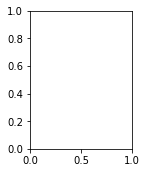

In [12]:
plt.figure(figsize=(15,30))
top_show = 3
pc_show  = 10
pltcnt = 1
for pc in range(pc_show):
    top_scoring = np.argsort(XPCA[:, pc])[-top_show:]
    bot_scoring = np.argsort(XPCA[:, pc])[top_show:]

    # Show PC
    plt.subplot(pc_show, (2*top_show)+1, pltcnt)  
    comp = PCS[pc,:]
    comp = (comp - np.min(comp)) / (np.max(comp) - np.min(comp))
    plt.imshow(np.reshape(comp,img_dim))
    plt.title('PC %s' % str(pc+1), fontsize=16)

    pltcnt+=1
    # Show hi-scoring
    for i in range(top_show):
        plt.subplot(pc_show, (2*top_show)+1, pltcnt)    
        plt.imshow(X[top_scoring[i], :, :, :])
        plt.title('Hi Score # %s' % str(i+1), fontsize=16)
        pltcnt+=1
        
    for i in range(top_show):
        plt.subplot(pc_show, (2*top_show)+1, pltcnt)    
        plt.imshow(X[bot_scoring[i], :, :, :])
        plt.title('Lo Score # %s' % str(i+1), fontsize=16)
        pltcnt+=1        
        
plt.tight_layout()

/Users/eric/anaconda/envs/tf35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


                   precision    recall  f1-score   support

     Ariel_Sharon       0.57      0.67      0.62         6
     Colin_Powell       0.86      0.83      0.84        23
  Donald_Rumsfeld       0.83      0.56      0.67        18
    George_W_Bush       0.77      0.92      0.84        48
Gerhard_Schroeder       0.57      0.67      0.62        12
      Hugo_Chavez       0.33      0.29      0.31         7
   Jacques_Chirac       0.20      0.20      0.20         5
    Jean_Chretien       0.44      0.80      0.57         5
    John_Ashcroft       1.00      0.67      0.80         6
Junichiro_Koizumi       1.00      0.83      0.91         6
  Serena_Williams       1.00      0.75      0.86         4
       Tony_Blair       0.58      0.70      0.64        10
   Vladimir_Putin       0.40      0.18      0.25        11

      avg / total       0.71      0.70      0.69       161



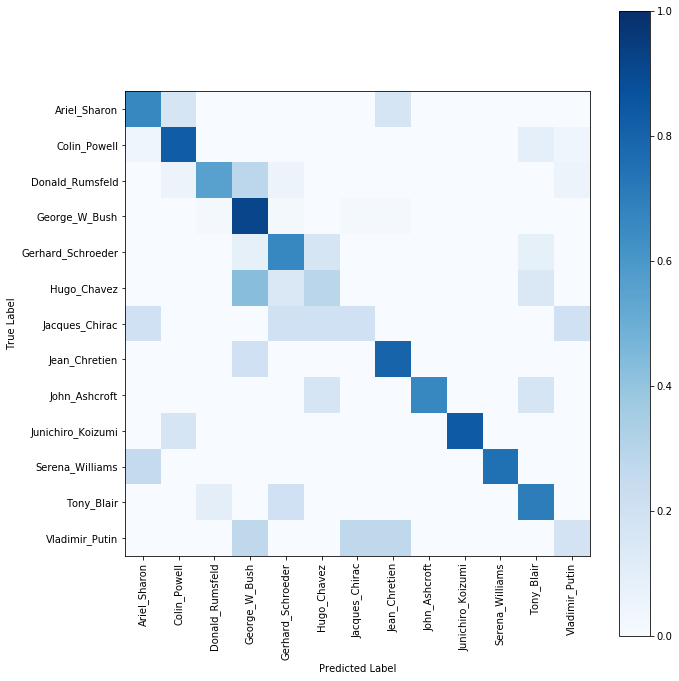

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

#--- Fit the Perceptron ---#
mlr = LogisticRegression(solver='sag', max_iter=1000, multi_class='multinomial')
mlr.fit(XPCA, y)

#--- Transform and predict test data ---#
ypred = mlr.predict(pca.transform(XFlat_test))

#--- Show results on test data ---#
print(classification_report(y_test, ypred, target_names=names))

#--- Calculate Confusion Matrix ---#
cmat = confusion_matrix(y_test, ypred).astype(np.float)
# Normalization...
for i in range(cmat.shape[0]):
    cmat[i,:] = cmat[i,:] / np.sum(cmat[i,:])
# Display...
plt.figure(figsize=(10,10))    
plt.imshow(cmat, vmin=0, vmax=1, cmap='Blues') 
plt.yticks(range(len(names)),names)
plt.xticks(range(len(names)),names,rotation='vertical')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.colorbar()
plt.tight_layout()

So, as we can see, we are able to get a pretty adequate level of classification perfomance just from a multinomial logistic regression on the top 100 principal component features. This is a simple approach that gives us an effective classifier. Now the question remains, can we do much better? Certainly there are other approaches we could use (CARTS, Boosting, etc.) for the classification/regression. However, lets take this opportunity to apply CNNs to this image classification task.

## CNNs for Face Classification
---

Now lets take a look at using a CNN for this same task. For some great references on CNN design, see

* [Stanford CNNs for Visual Recog Class](http://cs231n.github.io/convolutional-networks/)

We will explain the structure of CNNs and how they can be applied to images on the blackboard. In this notebook, we will focus on one particular structure and then leave it as an exercise to attempt to boost it. Our initial structure will be:

* **[Input] -> [Conv -> ReLu -> Conv -> ReLu -> MaxPool]x2 -> Dense -> ReLu -> Dropout -> Labels **

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import to_categorical
from keras.optimizers import SGD

input_dim = (X.shape[1], X.shape[2], X.shape[3])
#--- Network Structure ---#
faceNet = Sequential()

# First Convolution Block
faceNet.add(Conv2D(32, 
                   kernel_size=(3,3), 
                   data_format='channels_last', 
                   input_shape=input_dim, 
                   activation='relu'))
faceNet.add(Conv2D(32, 
                   kernel_size=(3,3), 
                   activation='relu'))
faceNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Second Convolution Block
faceNet.add(Conv2D(32, 
                   kernel_size=(3,3), 
                   activation='relu'))
faceNet.add(Conv2D(32, 
                   kernel_size=(3,3), 
                   activation='relu'))
faceNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# To Fully Connected Layer
faceNet.add(Flatten())
faceNet.add(Dense(128, activation='relu'))
faceNet.add(Dropout(0.2))

# Final Labels
faceNet.add(Dense(num_people, activation='softmax'))

#--- Training ---#
# Set Parameters
faceNet.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

# Get class weights
class_counts = np.histogram(y, bins=num_people)[0]
class_weight = class_counts / np.max(class_counts)

# Run Training
train_history = faceNet.fit(X, to_categorical(y), validation_split=0.05, epochs=10, verbose=1, batch_size=32, class_weight=class_weight)

# Save model parameters
faceNet.save('faceNet.h5')

Train on 1375 samples, validate on 73 samples
Epoch 1/10
1375/1375 [==============================] - 20s - loss: 2.2809 - acc: 0.3040 - val_loss: 2.0320 - val_acc: 0.3973

In [27]:
# ypred = faceNet.predict(X_test)
ypred = faceNet.predict_classes(X_test)

160/161 [============================>.] - ETA: 0s

                   precision    recall  f1-score   support

     Ariel_Sharon       0.57      0.67      0.62         6
     Colin_Powell       0.91      0.91      0.91        23
  Donald_Rumsfeld       1.00      0.72      0.84        18
    George_W_Bush       0.84      0.98      0.90        48
Gerhard_Schroeder       0.91      0.83      0.87        12
      Hugo_Chavez       0.67      0.86      0.75         7
   Jacques_Chirac       0.33      0.20      0.25         5
    Jean_Chretien       0.83      1.00      0.91         5
    John_Ashcroft       1.00      1.00      1.00         6
Junichiro_Koizumi       0.75      1.00      0.86         6
  Serena_Williams       1.00      0.75      0.86         4
       Tony_Blair       1.00      0.90      0.95        10
   Vladimir_Putin       1.00      0.64      0.78        11

      avg / total       0.87      0.86      0.85       161



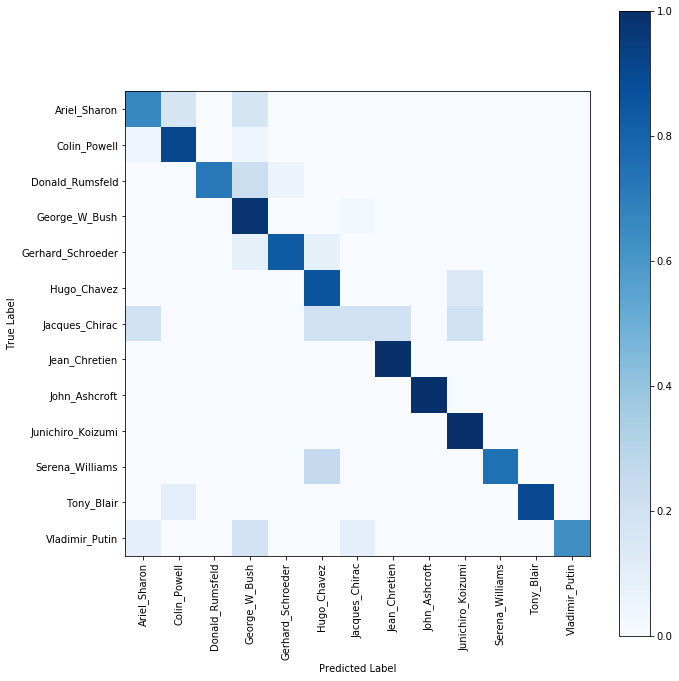

In [28]:
#--- Show results on test data ---#
print(classification_report(y_test, ypred, target_names=names))

#--- Calculate Confusion Matrix ---#
cmat = confusion_matrix(y_test, ypred).astype(np.float)
# Normalization...
for i in range(cmat.shape[0]):
    cmat[i,:] = cmat[i,:] / np.sum(cmat[i,:])
# Display...
plt.figure(figsize=(10,10))    
plt.imshow(cmat, vmin=0, vmax=1, cmap='Blues') 
plt.yticks(range(len(names)),names)
plt.xticks(range(len(names)),names,rotation='vertical')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.colorbar()
plt.tight_layout()

Now lets take a look at what we missed. It is often illuminating to understand the kinds of features common to the mistaken samples. In this case, we shouldn't fine tune our approach since we are looking at the errors on the *test* set. However, academically, we can see that many of these images exhibit atypical features. For example, a person wearing an uncommon clothing item, having a portion of their face obscured, unusal lighting or angles, or even just mislabeled/aligned data.

/Users/eric/anaconda/envs/tf35/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


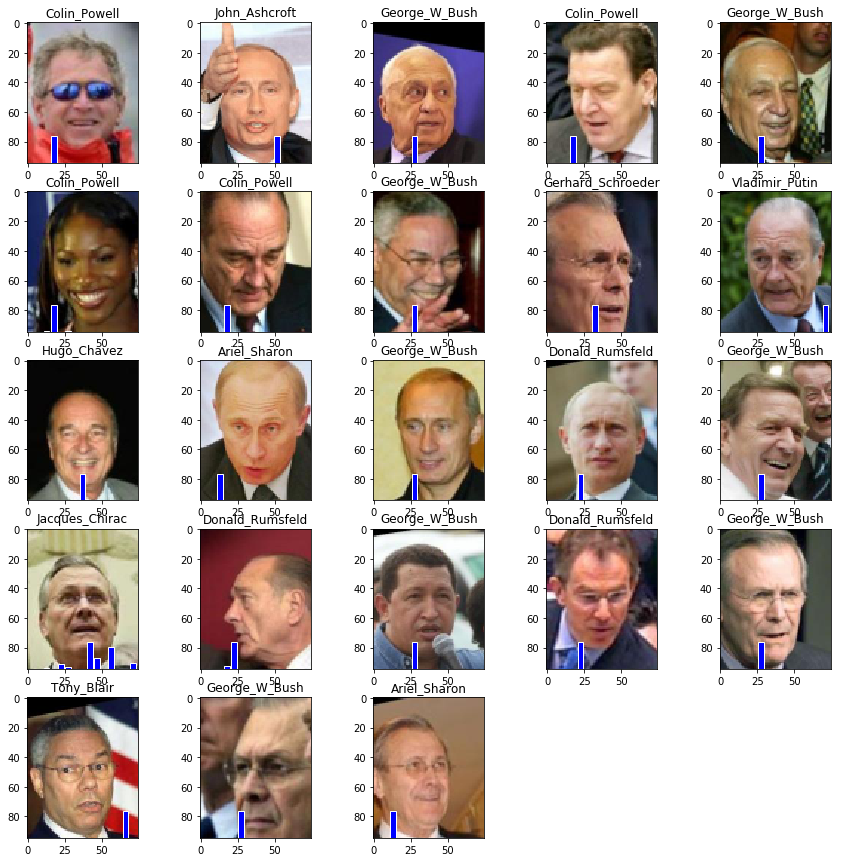

In [106]:
test_errors = np.where(np.not_equal(y_test, ypred))[0]
L = int(len(test_errors) / 5) + 1

plt.figure(figsize=(15,15))
pltidx = 1

def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

for i in range(len(test_errors)):
    im = np.empty((1, X_test.shape[1], X_test.shape[2], X_test.shape[3]), dtype=float)
    im[0,:,:,:] = X_test[i, :, :, :]
    
    ax = plt.subplot(L, 5, pltidx)
    plt.imshow(X_test[test_errors[i], :, :, :])
    plt.title(names[ypred[i]])
    sax = add_subplot_axes(ax, [0.2, 0.0, 0.7, 0.2])
    sax.bar(range(num_people),faceNet.predict(im).ravel(), color='b', edgecolor='w')
    sax.axis('off')
    
    pltidx += 1
    

